# Build a graph of a pytorch based model

In this tutorial, we walk you through the steps of building a graph of a pytorch model.  The example chosen will be the Dit-XL/2 Model.  Note that many of these steps mirror what you see here: https://colab.research.google.com/github/facebookresearch/DiT/blob/main/run_DiT.ipynb.  More details on this model can be found at https://github.com/facebookresearch/DiT?tab=readme-ov-file 

The assumption is that this notebook has access to a machine with a Tenstorrent device and that tt-metal has been successfully built.

We will follow these steps:
- Clone the library from https://github.com/facebookresearch/DiT.git
- Download DiT-XL
- Sample from the Pre-trained DiT Models and build the graph
- Display the graph

## Clone the library from https://github.com/facebookresearch/DiT.git

In [1]:
import ttnn

!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
# We have a name collision in python's namespace with ttnn using models and models also existing in DiT
# So here we just append DiT to the front.
from DiT.models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")


2024-04-05 05:49:00.322 | INFO     | ttnn:<module>:28 - ttnn: model cache was enabled


fatal: destination path 'DiT' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Requirement already up-to-date: diffusers in /home/ubuntu/git/tt-metal/build/python_env/lib/python3.8/site-packages (0.27.2)
Requirement already up-to-date: timm in /home/ubuntu/git/tt-metal/build/python_env/lib/python3.8/site-packages (0.9.16)
GPU not found. Using CPU instead.


## Download DiT-XL/2 Models

In [2]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

## Sample from Pre-trained DiT Models and build the graph


  0%|          | 0/250 [00:00<?, ?it/s]

2024-04-05 06:21:17.987 | INFO     | ttnn.tracer:visualize:210 - Dumping graph of the model to /tmp/ttnn/dit_model_graph.svg


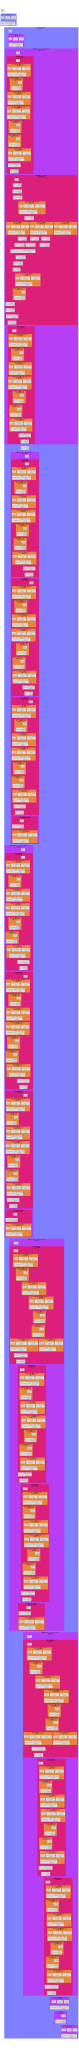

In [3]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

# Here is where we capture the graph into an svg!
with ttnn.tracer.trace():
    samples = vae.decode(samples / 0.18215).sample
    
ttnn.tracer.visualize(samples, file_name=ttnn.TMP_DIR / "dit_model_graph.svg")

# Optionally Save and display images from DiT:
# save_image(samples, "sample.png", nrow=int(samples_per_row), 
#            normalize=True, value_range=(-1, 1))
# samples = Image.open("sample.png")
# display(samples)

## Display the graph

In [ ]:
from IPython.display import SVG, display
def show_svg():
    return SVG(filename=ttnn.TMP_DIR / "dit_model_graph.svg")

show_svg()